In [0]:
# Ben Hawks, z1849064, CSCI480 - Applied Machine Learning, Spring 2020
%matplotlib inline
!pip install SHAP
!pip install pycebox
!pip install rfpimp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl


In [0]:
data_cols = ["fixed acidity","volatile acidity","citric acid","residual sugar",
             "chlorides","free sulfur dioxide","total sulfur dioxide","density",
             "pH","sulphates","alcohol","quality"]


train_data_url='https://raw.githubusercontent.com/pratoolbharti/Applied_Machine_Learning_S20/master/Data-HW4/winequality-white.csv'
train_data = pd.read_csv(train_data_url,na_values="",keep_default_na=False,delimiter=";")
train_data_X = train_data.drop('quality',1)
train_data_Y = train_data.quality
train_data_X.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


In [0]:
from sklearn.model_selection import RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor

param_grid = {'n_estimators': range(10,16),
              'max_features': range(2,12),
              'max_leaf_nodes': range(2,50),
              'max_depth': range(2,10),
              'min_samples_leaf':range(10,261,50)} #10,50,60,...,260


#Don't need much preprocessing here, the dataset is a bit imbalanced, but because this is being treated as a regression problem, 
#resampling "classes" dont make much sense
#fixing random state for sake of repeatibility, in my experince values fluxuated around 0.3 +- 0.02
rforest = RandomizedSearchCV(RandomForestRegressor(random_state=1849064),param_grid,scoring="r2",n_jobs=10,cv=10,random_state=1849064)
rforest.fit(train_data_X,train_data_Y)  
print("Got best score for Random Forest with params " + str(rforest.best_params_) + ": " + str(rforest.best_score_))
 
best_rforest = rforest.best_estimator_



Got best score for Random Forest with params {'n_estimators': 12, 'min_samples_leaf': 60, 'max_leaf_nodes': 28, 'max_features': 4, 'max_depth': 9}: 0.2876122262031293


Part 2 - Ranking Drop Feature(Column) Importance

                      Importance
Feature                         
volatile acidity        0.021474
free sulfur dioxide     0.015779
alcohol                 0.015684
residual sugar          0.002471
citric acid            -0.002774
total sulfur dioxide   -0.002999
chlorides              -0.003885
fixed acidity          -0.004691
density                -0.005454
pH                     -0.006522
sulphates              -0.006797


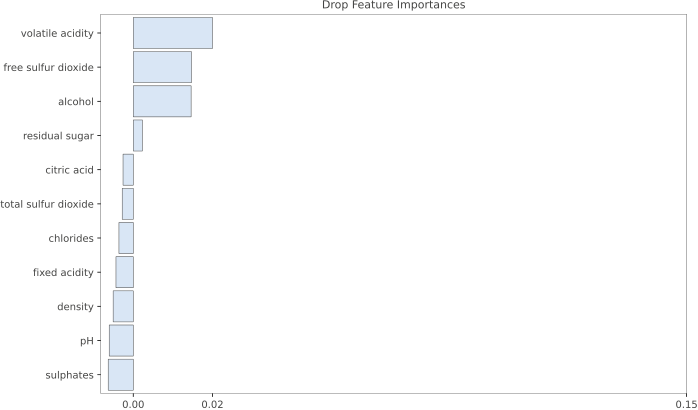

In [104]:
from sklearn.inspection import partial_dependence,plot_partial_dependence
from rfpimp import dropcol_importances,plot_importances #library to evaluate drop column (feature) imporances, among others

drop_imp = dropcol_importances(best_rforest,train_data_X,train_data_Y)
print(drop_imp)

drop_plt = plot_importances(drop_imp, title="Drop Feature Importances",width=10,minheight=6,)
drop_plt

It seems that the "Volatile Acidity","Free Sulphur Dioxide", "Alcohol" and "Residual Sugar" seem to be important, but everything else seem to make the make the model perform worse 

Part 3 - Permutation Importance

                      Importance
Feature                         
alcohol                 0.241217
volatile acidity        0.109620
free sulfur dioxide     0.069221
density                 0.058267
residual sugar          0.027996
chlorides               0.020542
total sulfur dioxide    0.018722
citric acid             0.018365
fixed acidity           0.010735
sulphates               0.008985
pH                      0.008260


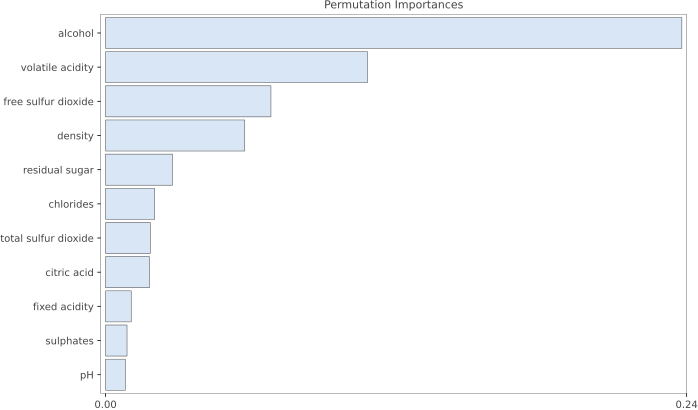

In [0]:
from sklearn.inspection import permutation_importance
from rfpimp import permutation_importances as rfp
from sklearn.metrics import r2_score


def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

#perm_imp = permutation_importance(best_rforest,train_data_X,train_data_Y,n_repeats=10,n_jobs=10,random_state=1849064)
#results from the sklearn model are similar enough vs rfpimp, easy graphic via RFPIMP though
perm_imp = rfp(best_rforest,train_data_X,train_data_Y,r2)
print(perm_imp)
plot_importances(perm_imp, title="Permutation Importances",width=10,minheight=6)

This is an interesting result, the top 3 results here also correspond to the drop column results, but in this case "density" is shown as having higher importance than "residual sugar" does, where desity was shown to have a negitive effect according to drop column importance

Part 4 - 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


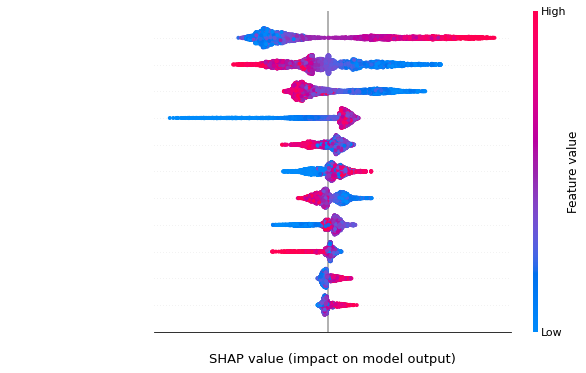

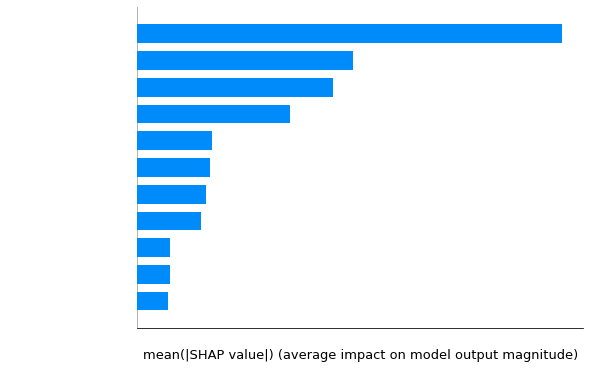

In [0]:
import shap 

shap_values = shap.TreeExplainer(best_rforest).shap_values(train_data_X)
shap.summary_plot(shap_values, train_data_X,axis_color='#FFFFFF')
shap.summary_plot(shap_values, train_data_X,axis_color='#FFFFFF', plot_type="bar",)



In this case, the SHAP values point towards some similar points to the previous plots, though not exactly the same. It seems that the top few features remain mostly the same, with "Alcohol", "Volatile Acidity","Free Sulphur Dioxide" still remaining in the top 4, and "Density" also showing up agian, though this time in spot 3 vs spot 4. 



Part 5 - Partial Dependance Plot

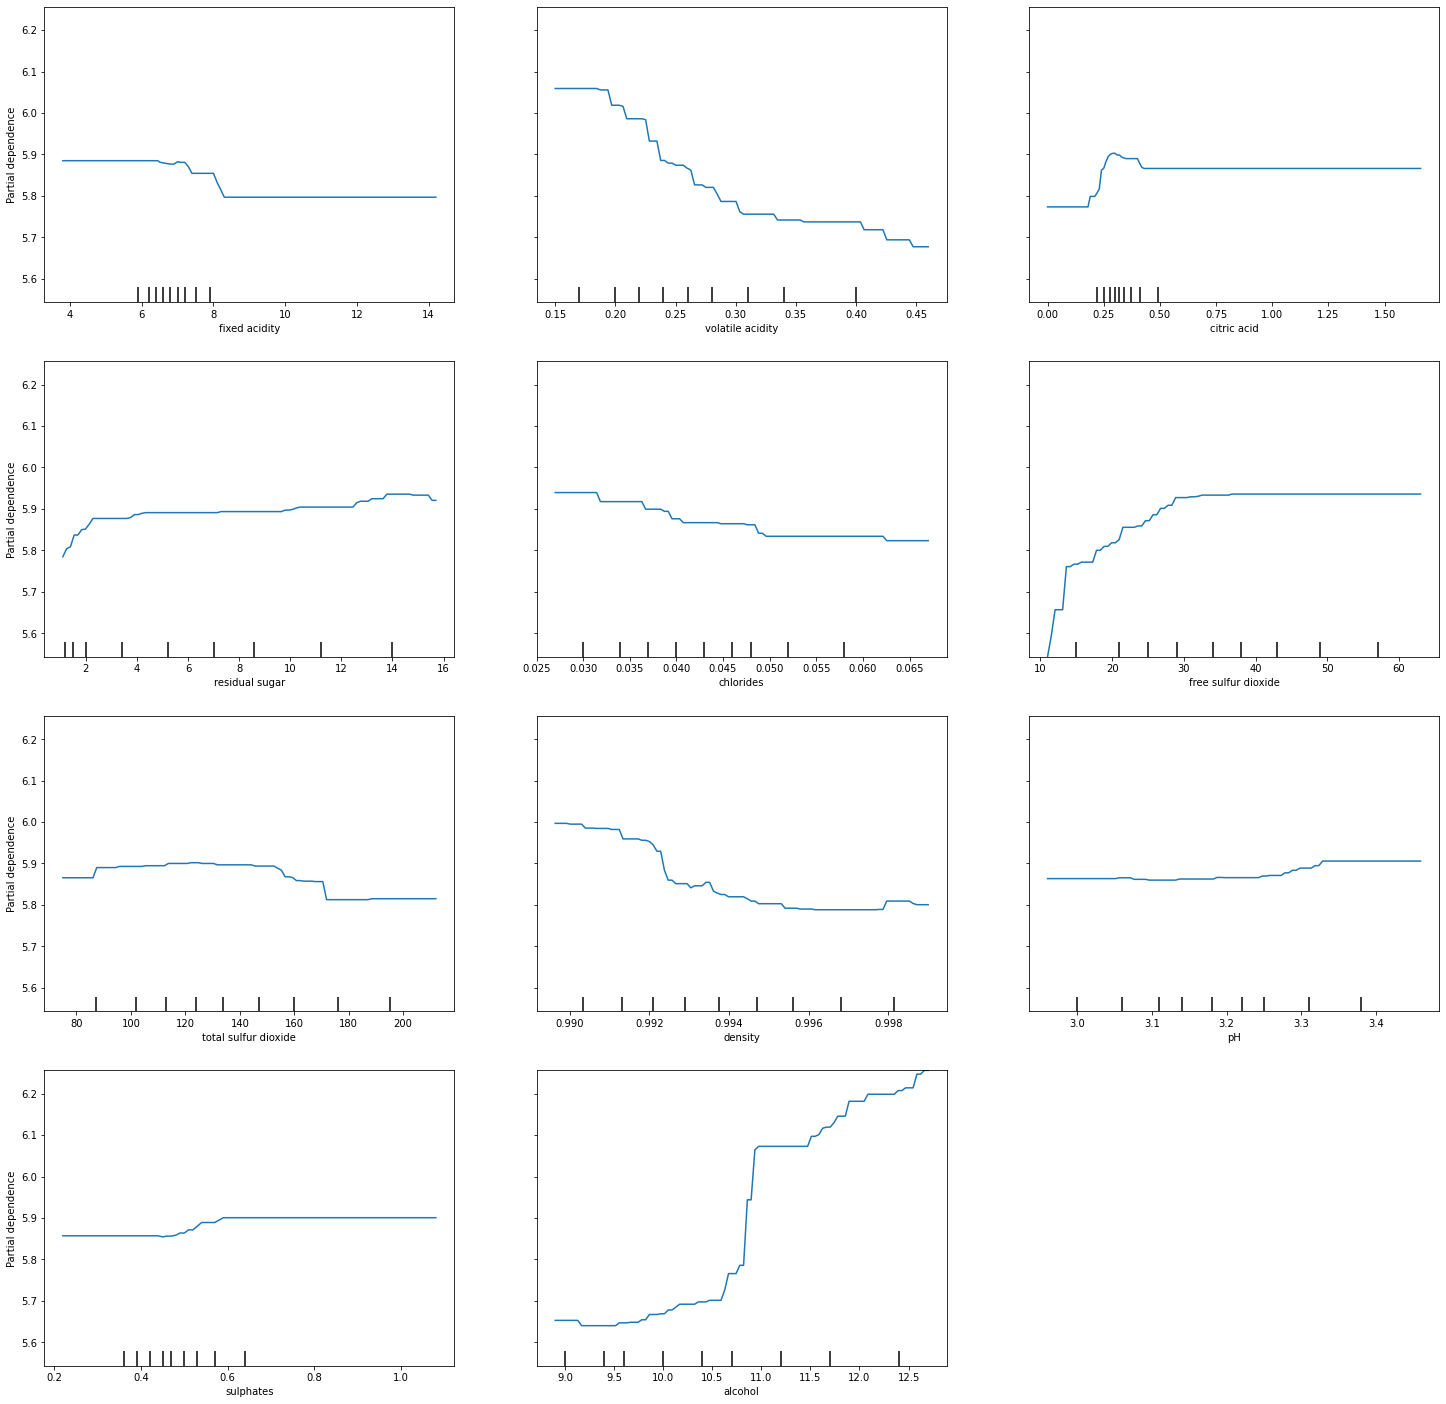

In [0]:
if len(data_cols) == 12:
  data_cols.remove("quality")
pdp = plot_partial_dependence(best_rforest,train_data_X,data_cols)
fig = plt.gcf()
fig.set_figheight(25)
fig.set_figwidth(25)

These plots seem to also show similar results, with the top ~4 features from before being the ones who have the most "obvious" trends, and the features that don't have much of an effect have a trend that is more or less flat.

Part 6 - 

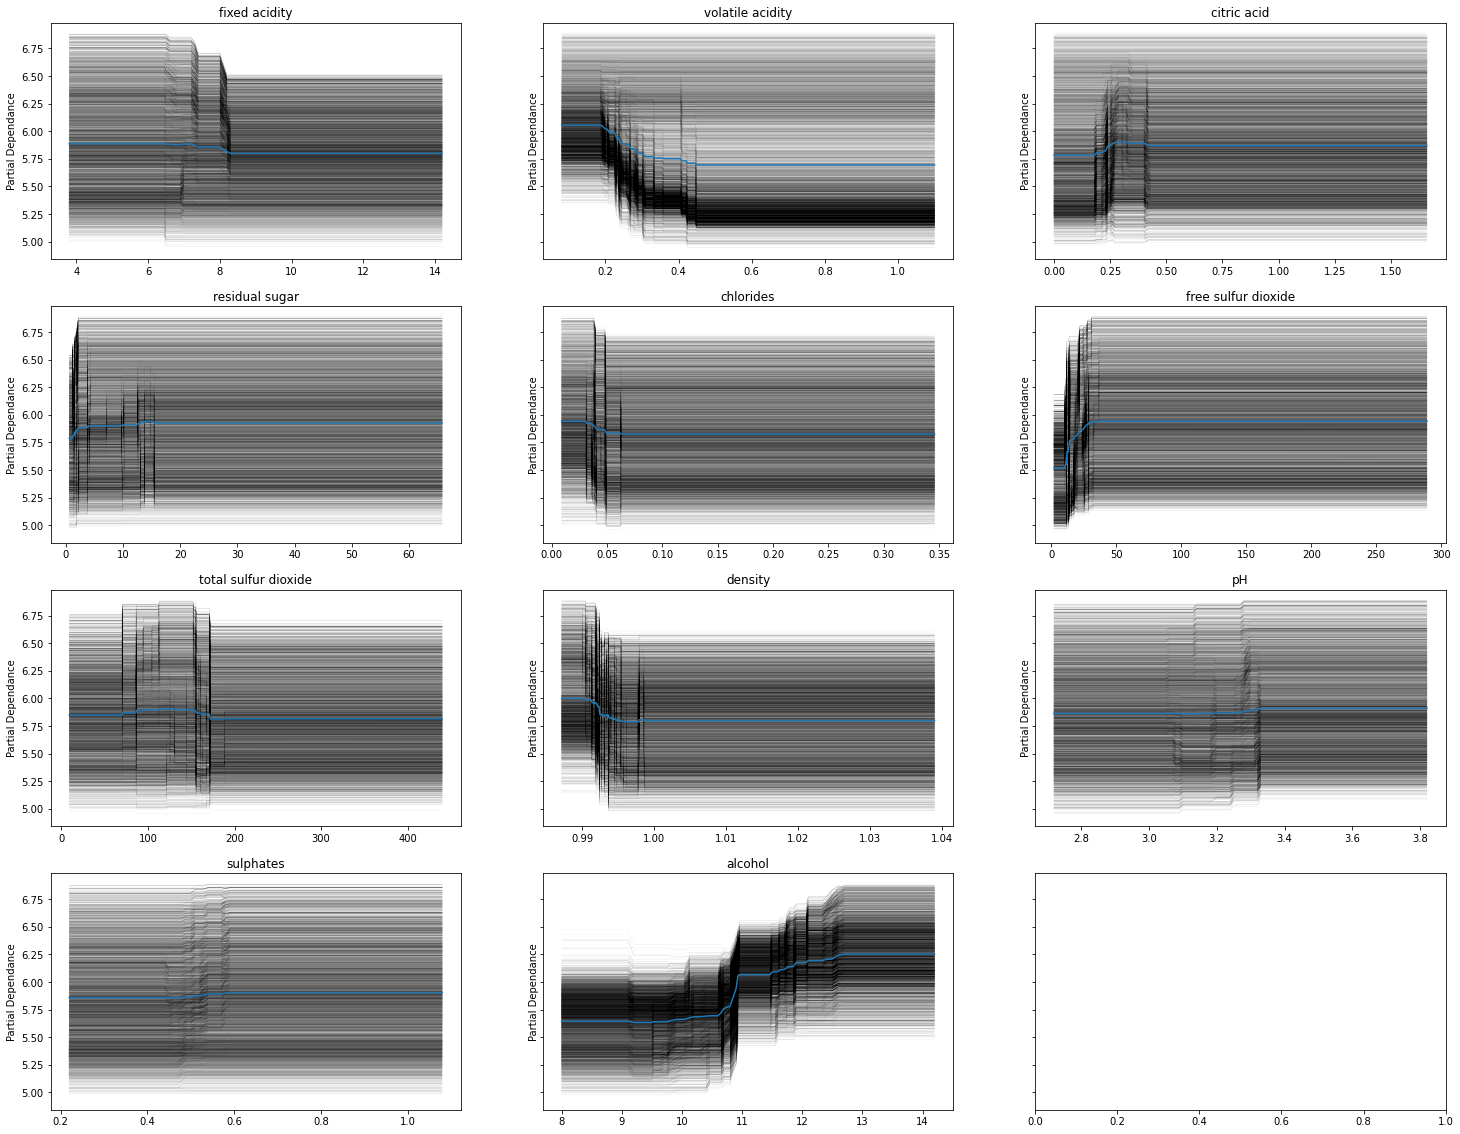

In [102]:
from pycebox.ice import ice,ice_plot 

ig, axes = plt.subplots(4, 3, figsize=(25, 20),sharey=True) #Based of the example from your slides/notebook for slieds
for feature, ax in zip(data_cols, axes.ravel()):
    ice_df = ice(train_data_X, feature, best_rforest.predict)
    ice_plot(ice_df, frac_to_plot=10, plot_pdp=True,
             c='k', alpha=0.1, linewidth=0.3, ax=ax)
    ax.set_title(feature)
    ax.set_ylabel("Partial Dependance")

The purpose of the icebox plot is to show activity of the whole set of partial dependance values that the mean itself might not expose on its own, overall there doesn't seem to be anything to unexpected in the behavior of the dataset as a whole vs just the mean, so the important features found here are the same as beore 

Part 7 - Analysis etc. 

Overall, each of the feature selectors here seemed to agree in broad strokes of which features are important, but each algorithm/metric had different ideas on why/how each feature was important, and what order of importantce they held. Overall the "alchohol" and "volitile acidity" held stong across all metrics as being "important" , along with "free sulphur dioxide", "density" and "Residual Sugar" to a lesser degree. Out of all the techniques here, I think I found the SHAP scores the most useful, as it actually showed how the features affected the target and the "distribution" of effects on the target, and really gave a better picture of feature importance than other metrics. 